# 演習20: サンプルコードを実行し，エピガロカテキン(Epigallocatechingallate)に変異・挿入・欠失・伸長の操作を施し，生成される化学構造を可視化せよ.

ライブラリーの読み込み

In [1]:
from rdkit import Chem, DataStructs
from rdkit.Chem import Draw
import numpy as np
import random
import re
import math

### PointMutation

点変異を発生させるメソッド

#### input
- __smi__: str  
　　対象のSMILES
- __max_iter__: int  
　　最大試行回数（デフォルト100回）。
- __weightr__: list(int)  
　　原子を選択する場合の重み。
- __atm_list__: list(int)  
　　選択されうる原子番号。
- __seed__: int  
　　乱数(-1の場合は固定しない(デフォルト))。

  
#### output
- __fsmi__: str  

In [2]:
def PointMutation(smi, max_iter=100, weight=[1, 1, 1,1], atm_list=[6,7,8,16], seed=-1):
    smiles = smi

    if (smiles is np.nan) or (smiles is None):
        return None
    if len(weight) != len(atm_list) :
        return None

    if seed == -1:
        pass
    else:
        random.seed(seed)
        
    for i in range(max_iter):
        w=weight.copy()

        mol = Chem.MolFromSmiles(smiles)
        pos = mol.GetNumAtoms() - 1
        idx = random.randint(0,pos)
        
        an = mol.GetAtomWithIdx(idx).GetAtomicNum()
        w[atm_list.index(an)] = 0
        
        chg_atm = random.choices(atm_list, k=1, weights=w)
        mol.GetAtomWithIdx(idx).SetAtomicNum(chg_atm[0])
        
        try:
            Chem.SanitizeMol(mol)
        except:
            continue
        break

    if mol is not None:
        fsmi = Chem.MolToSmiles(mol)
        return fsmi
    else:
        return None

### Insert

挿入

#### input
- __smi__: str  
　　対象のSMILES
- __max_iter__: int  
　　最大試行回数（デフォルト100回）。
- __weightr__: list(int)  
　　原子を選択する場合の重み。
- __atm_list__: list(str)  
　　選択されうる原子のSMILES記法。
- __add_halogen__: list(str)  
　　ハロゲンを選択肢に加える(デフォルトはFalse)。
- __eff_ring__: list(str)  
　　環状構造へ積極的に挿入する(デフォルトはFalse)。
- __seed__: int  
　　乱数(-1の場合は固定しない(デフォルト))。
  
#### output
- __fsmi__: str  

In [3]:
def Insert(smi, max_iter=100, weight=[1, 1, 1,1], a_list=['C','N','O','S'], add_halogen=False, eff_ring=False, seed=-1):
    smiles = smi
    w=weight.copy()
    atm_list = a_list.copy()
    
    if (smiles is np.nan) or (smiles is None):
        return None
    
    if seed == -1:
        pass
    else:
        random.seed(seed)
    
    if add_halogen is True:
        atm_list.extend(['F', 'Cl', 'Br'])
        w.extend([1, 1, 1])
        
    if len(w) != len(atm_list) :
        return None
    
    for j in range(max_iter): 
        mol = Chem.MolFromSmiles(smiles)
        Chem.Kekulize(mol)
        pos = mol.GetNumAtoms() - 1
        idx = random.randint(0,pos)
        nsmi = Chem.MolToSmiles(mol,rootedAtAtom=idx)

        ins_pos = random.randint(0,len(nsmi)-1)
        ins_atm = random.choices(atm_list, k=1, weights=w)
        
        if eff_ring is False:
            rsmi = ins_atm[0]+nsmi
        else:
            rsmi = nsmi[:ins_pos]+ins_atm[0]+ nsmi[ins_pos:]
        
        print(pos, idx, ins_pos, ins_atm)
        
        mol_rsmi = Chem.MolFromSmiles(rsmi)
        
        try:
            Chem.SanitizeMol(mol_rsmi)
        except:
            continue
        break

    if mol_rsmi is not None:
        fsmi = Chem.MolToSmiles(mol_rsmi)
        return fsmi
    else:
        return None

### Deletion

欠損

#### input
- __smi__: str  
　　対象のSMILES
- __max_iter__: int  
　　最大試行回数（デフォルト100回）。
- __eff_ring__: list(str)  
　　環状構造へ積極的に挿入する(デフォルトはFalse)。
- __seed__: int  
　　乱数(-1の場合は固定しない(デフォルト))。
  
#### output
- __fsmi__: str  

In [4]:
def Deletion(smi, max_iter=100, eff_ring=False, seed=-1):
    smiles = smi

    if (smiles is np.nan) or (smiles is None):
        return None
        
    if seed == -1:
        random.seed()
    else:
        random.seed(seed)
        
    for j in range(max_iter): 
        mol = Chem.MolFromSmiles(smiles)
        pos = mol.GetNumAtoms() - 1
        if pos < 0:
            pos = 0
        idx = random.randint(0,pos)
        nsmi = Chem.MolToSmiles(mol,rootedAtAtom=idx)

        if eff_ring is False:
            rsmi = nsmi[1:]
        else:
            del_pos = random.randint(0,len(nsmi)-1)
            rsmi = nsmi[:del_pos]+nsmi[del_pos+1:]
        
        mol_rsmi = Chem.MolFromSmiles(rsmi)
        
        try:
            Chem.SanitizeMol(mol_rsmi)
        except:
            continue
        break

    if mol_rsmi is not None:
        fsmi = Chem.MolToSmiles(mol_rsmi)
        return fsmi
    else:
        return None

### Duplication

重複

#### input
- __smi__: str  
　　対象のSMILES
- __max_iter__: int  
　　最大試行回数（デフォルト100回）。
- __eff_ring__: list(str)  
　　環状構造へ積極的に挿入する(デフォルトはFalse)。
- __seed__: int  
　　乱数(-1の場合は固定しない(デフォルト))。
  
#### output
- __fsmi__: str  

In [5]:
def Duplication(smi, max_iter=100, eff_ring=False, seed=-1):
    smiles = smi
    
    if (smiles is np.nan) or (smiles is None):
        return None
        
    if seed == -1:
        random.seed()
    else:
        random.seed(seed)
    
    for j in range(max_iter): 
        fsmi_list = []
        mol = Chem.MolFromSmiles(smiles)
        idx = random.randint(0,(mol.GetNumAtoms()-1))
        nsmi = Chem.MolToSmiles(mol,rootedAtAtom=idx)

        if eff_ring is False:
            rsmi = nsmi[0] + nsmi
        else:
            dup_pos = random.randint(0,len(nsmi)-1)
            rsmi = nsmi[:dup_pos]+nsmi[dup_pos-1:]
          
        mol_rsmi = Chem.MolFromSmiles(rsmi)
        
        try:
            Chem.SanitizeMol(mol_rsmi)
        except:
            continue
        break

    if mol_rsmi is not None:
        fsmi = Chem.MolToSmiles(mol_rsmi)
        return fsmi
    else:
        return None

In [13]:
if __name__ == '__main__':
    smi = "O=C(O[C@@H]2Cc3c(O[C@@H]2c1cc(O)c(O)c(O)c1)cc(O)cc3O)c4cc(O)c(O)c(O)c4"
    mols = []
    smiles = []
    for i in range(50):
        rsmi = PointMutation(smi)
        #rsmi = Insert(smi)
        #rsmi = Deletion(smi)
        #rsmi = Duplication(smi)
        
        smiles.append(rsmi)

    # 重複構造の削除
    smiles_list = list(set(smiles))    
    
    for smi in smiles_list:
        mols.append(Chem.MolFromSmiles(smi))

RDKit ERROR: [17:47:35] Can't kekulize mol.  Unkekulized atoms: 24 26 28 30 32
[17:47:35] Can't kekulize mol.  Unkekulized atoms: 24 26 28 30 32

RDKit ERROR: 
RDKit ERROR: [17:47:35] Can't kekulize mol.  Unkekulized atoms: 5 6 18 19 21
RDKit ERROR: 
[17:47:35] Can't kekulize mol.  Unkekulized atoms: 5 6 18 19 21

RDKit ERROR: [17:47:35] Can't kekulize mol.  Unkekulized atoms: 9 10 13 15 17
[17:47:35] Can't kekulize mol.  Unkekulized atoms: 9 10 13 15 17

RDKit ERROR: 
RDKit ERROR: [17:47:35] Can't kekulize mol.  Unkekulized atoms: 24 25 26 28 30
[17:47:35] Can't kekulize mol.  Unkekulized atoms: 24 25 26 28 30

RDKit ERROR: 
RDKit ERROR: [17:47:35] Can't kekulize mol.  Unkekulized atoms: 25 26 28 30 32
[17:47:35] Can't kekulize mol.  Unkekulized atoms: 25 26 28 30 32

RDKit ERROR: 
RDKit ERROR: [17:47:35] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [17:47:35] Explicit valence for atom # 1 N, 4, is greater than permitted
[17:47:35] Explicit valence for at

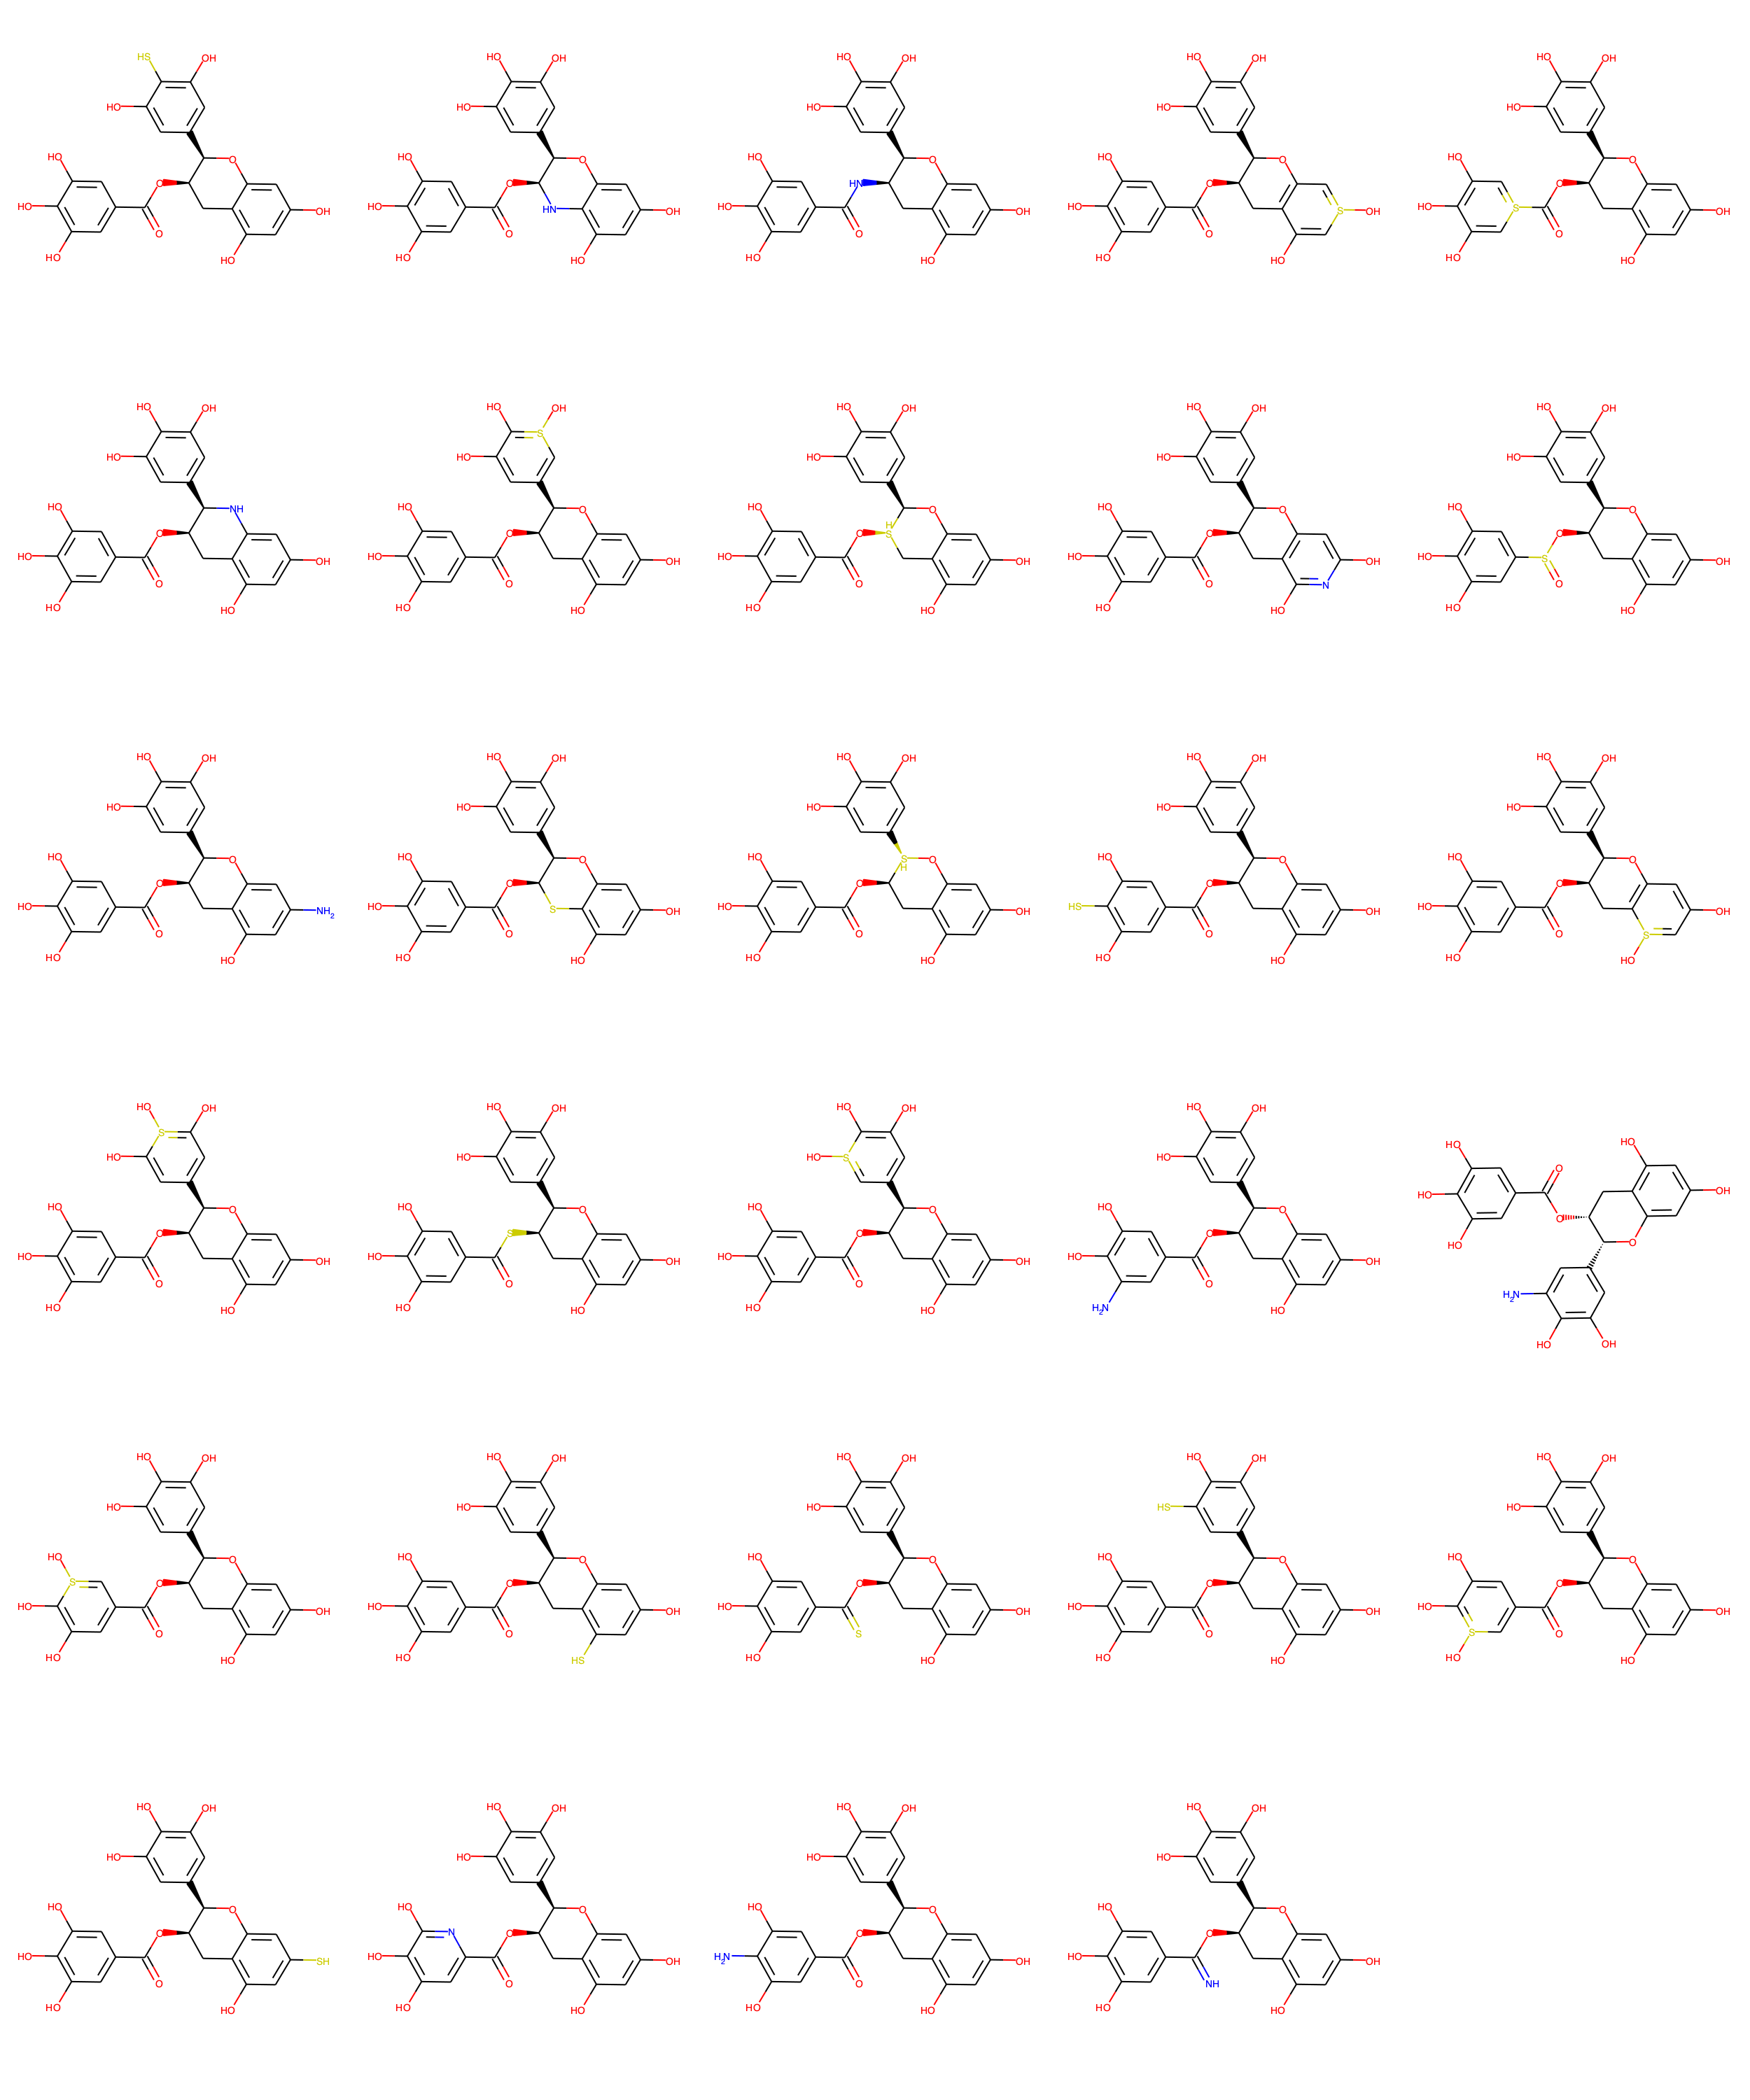

In [14]:
Draw.MolsToGridImage(mols,molsPerRow=5,subImgSize=(500,500))